# Fuzzy Clustering using QPSO

This notebook demonstrates how to apply fuzzy clustering algorithm to labeled multi-dimensional data to find cluster centers. 

## Summaries

* Generate a set of 2-dimensional data points with known labels.

* Apply the fuzzy clustering algorithm to the aforementioned data points.

* Visualize the results and check the validity of the cluster centers found by the algorithm.

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## import ExtractRulesQPSO class
import sys, os
sys.path.append(os.getcwd() + '/scripts')
from ExtractRulesQPSO import ExtractRulesQPSO
from FuzzyClustering import FuzzyClustering
from FuzzyRule import FuzzyRule

## Example application of the fuzzy clustering algorithm

### Generating synthetic data

We made the data points at the lower left as "Class 1", and those at the upper right as "Class 2".  

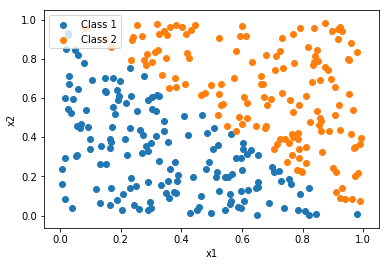

In [3]:
random_numbers = np.random.rand(1000)
N = 300  ## number of data points
tmp_c1 = []
tmp_c2 = []

for i in range(N):
    v_tmp = np.random.rand(2)
    
    if (v_tmp[0] + v_tmp[1] <= 1):
        tmp_c1.append(v_tmp)
    else:
        tmp_c2.append(v_tmp)

## Synthetic data for two classes
data_c1 = np.array(tmp_c1)
data_c2 = np.array(tmp_c2)

plt.scatter(data_c1[:,0], data_c1[:,1], label = 'Class 1')
plt.scatter(data_c2[:,0], data_c2[:,1], label = 'Class 2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend();

In [5]:
data_c1[0]

array([0.29661008, 0.06690637])

### Applying fuzzy clustering

In [7]:
fc1 = FuzzyClustering(data_c1)
fc2 = FuzzyClustering(data_c2)

In [8]:
## finding centers
fc1.extractClusteringCenters()
centers_c1 = fc1.getDenormalizedClusterCenters()
fc2.extractClusteringCenters()
centers_c2 = fc2.getDenormalizedClusterCenters()

In [9]:
centers_c1, centers_c2

(array([[0.23201137, 0.40676676],
        [0.55813968, 0.12659651],
        [0.11863633, 0.73801988]]), array([[0.63200332, 0.75705784],
        [0.26211454, 0.84677874],
        [0.95961162, 0.8293903 ],
        [0.79424332, 0.35600272]]))

In [10]:
centers_c1_df = pd.DataFrame(centers_c1)
num_rules_c1 = len(centers_c1)
centers_c1_df.columns = ['x' + str(i + 1) for i in range(len(centers_c1[0]))]
centers_c1_df['class_label'] = 'Y1'

centers_c2_df = pd.DataFrame(centers_c2)
num_rules_c2 = len(centers_c2)
centers_c2_df.columns = ['x' + str(i + 1) for i in range(len(centers_c2[0]))]
centers_c2_df['class_label'] = 'Y2'

In [11]:
all_class_centers = []
all_class_centers.append(centers_c1)
all_class_centers.append(centers_c2)

all_class_centers

[array([[0.23201137, 0.40676676],
        [0.55813968, 0.12659651],
        [0.11863633, 0.73801988]]), array([[0.63200332, 0.75705784],
        [0.26211454, 0.84677874],
        [0.95961162, 0.8293903 ],
        [0.79424332, 0.35600272]])]

In [12]:
centers_c1_df.loc[:, centers_c1_df.columns != 'class_label'].iloc[[2]]

,x1,x2
2,0.118636,0.73802


### Plotting resulting cluster centers

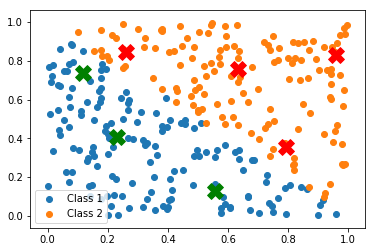

In [13]:
plt.scatter(data_c1[:,0], data_c1[:,1], label = 'Class 1')
plt.scatter(data_c2[:,0], data_c2[:,1], label = 'Class 2')

## Add centers of class 1
for cs in centers_c1:
    plt.scatter(cs[0], cs[1], marker = 'X', color = 'green', s = 250)

## Add centers of class 2
for cs in centers_c2:
    plt.scatter(cs[0], cs[1], marker = 'X', color = 'red', s = 250)

plt.legend()

## Use QPSO to optimize the rules

We can also assume Gaussian MFs of each of the cluster centers, with one addtional parameter _std_ for each of the MFs; then, we apply QPSO to optimize classification error defined in the __ExtractRulesQPSO__ class.

In [14]:
qpso = ExtractRulesQPSO(30, 50, 2 * (len(centers_c1) + len(centers_c2)))

In [15]:
qpso.solver([centers_c1, centers_c2], [data_c1, data_c2])

In [16]:
qpso.best_particle

array([ -0.07698203,  -0.15290237, -38.04894623,   0.08164881,
         0.05689061,  -5.30529861,  -8.0501557 , -21.67132127,
         2.83288126,  -3.76499801, -11.65275836,  -7.69429852,
         3.89661539,  10.36263975])

In [17]:
tuned_stds = ExtractRulesQPSO._arrangeStds(qpso.best_particle, all_class_centers)
tuned_stds

[array([[ -0.07698203,  -0.15290237],
        [-38.04894623,   0.08164881],
        [  0.05689061,  -5.30529861]]), array([[ -8.0501557 , -21.67132127],
        [  2.83288126,  -3.76499801],
        [-11.65275836,  -7.69429852],
        [  3.89661539,  10.36263975]])]

### Show rules for both classes

<Figure size 432x288 with 0 Axes>

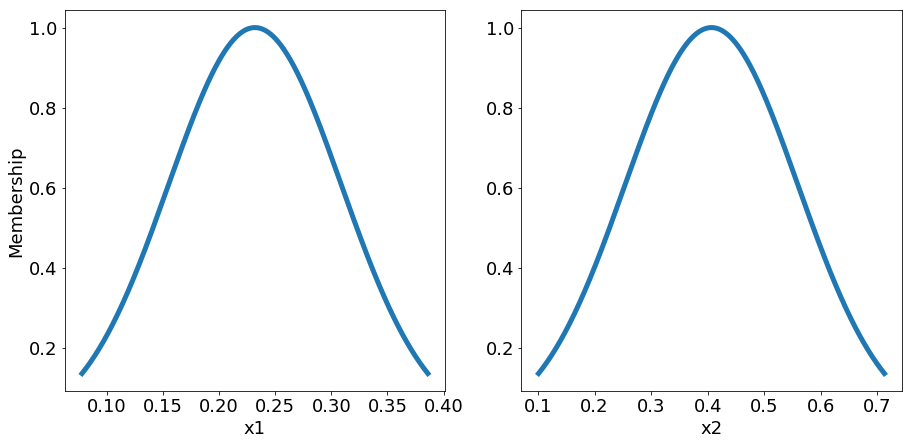

<Figure size 432x288 with 0 Axes>

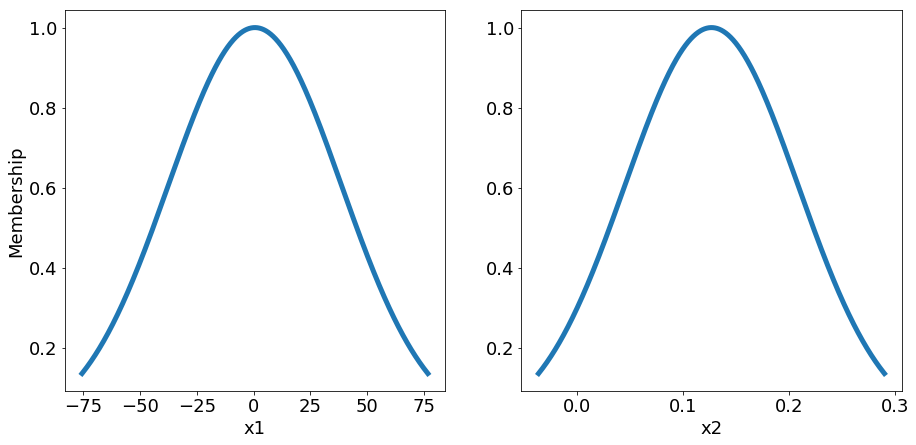

<Figure size 432x288 with 0 Axes>

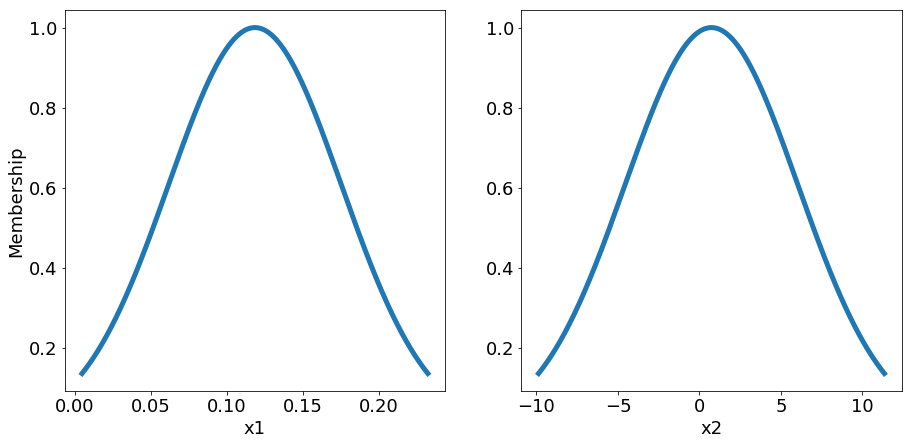

<Figure size 432x288 with 0 Axes>

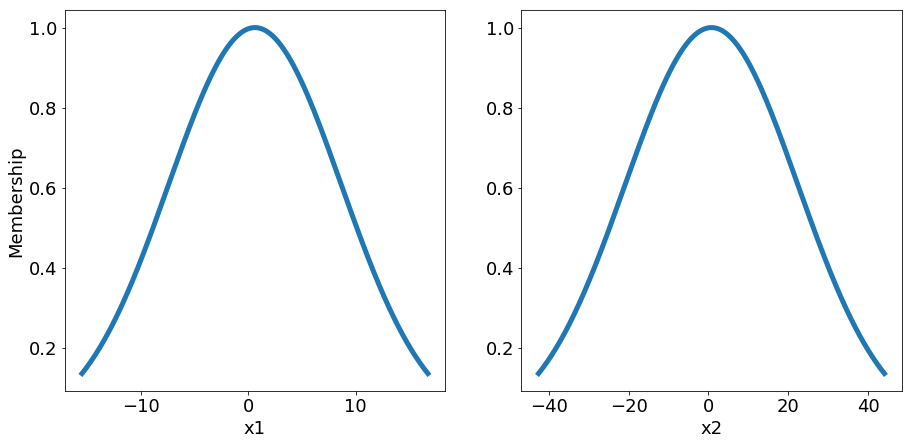

<Figure size 432x288 with 0 Axes>

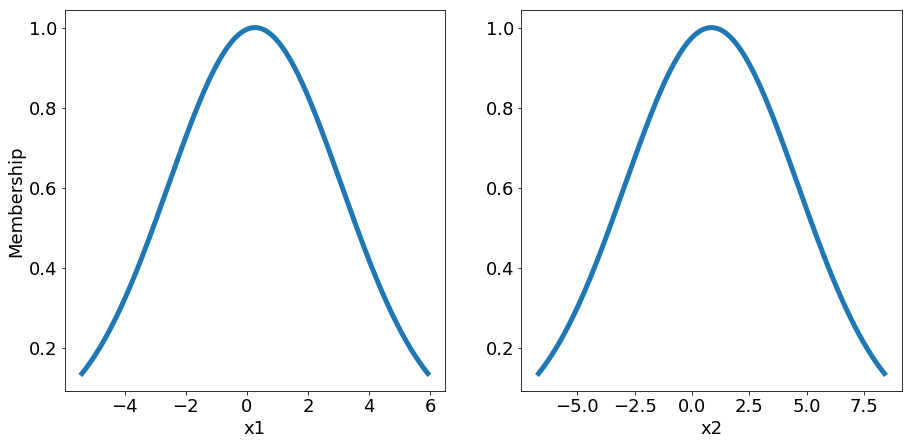

<Figure size 432x288 with 0 Axes>

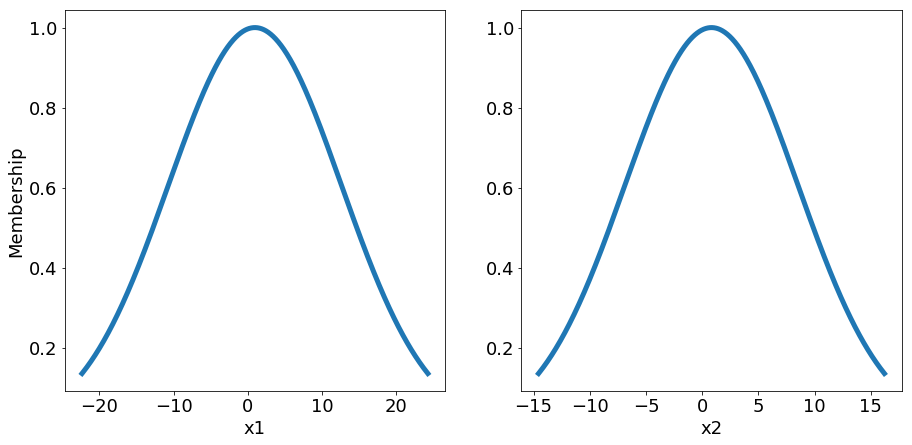

<Figure size 432x288 with 0 Axes>

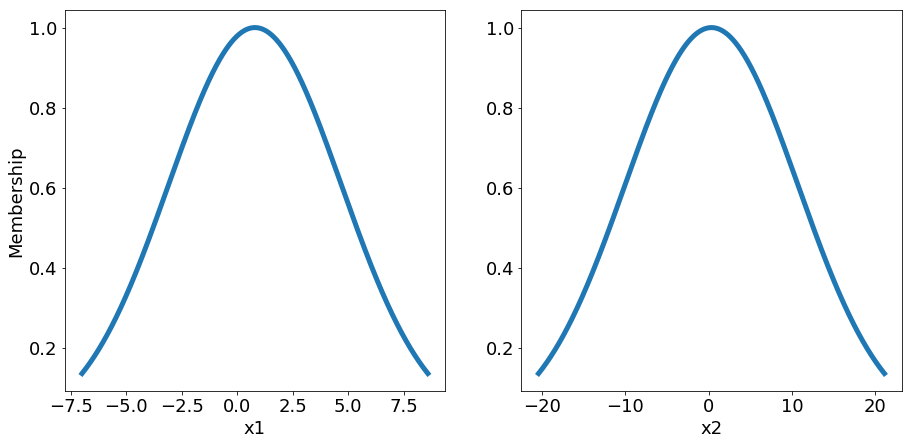

In [18]:
class_labels = ['Y1', 'Y2']

for all_centers, all_stds, class_label in zip(all_class_centers, tuned_stds, class_labels):
    # iterate through all classes
    
    for centers, stds in zip(all_centers, all_stds):
        # iterate through all rules
        rule = FuzzyRule(centers, stds, class_label)
        rule.plotRule()